In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
# data_root = 'dataset/image-search'
data_root = './dataset/image-search'
train_root = os.path.join(data_root,'train/train')
test_root = os.path.join(data_root,'test/images')
queries_path = os.path.join(data_root,'queries\queries')

print(train_root,'\n',test_root,'\n',queries_path)

./dataset/image-search\train/train 
 ./dataset/image-search\test/images 
 ./dataset/image-search\queries\queries


# Visualize Queries Labels

In [59]:
# Display Query Labels

def display_images_in_subplot(image_folder):
    image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    num_images = len(image_files)

    # Set the number of columns
    num_columns = 5
    num_rows = (num_images + num_columns - 1) // num_columns

    plt.figure(figsize=(15, 3 * num_rows))

    for i in range(num_images):
        img_path = image_files[i]
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)

        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(tf.cast(img_array, tf.uint8))
        plt.title(os.path.basename(img_path))
        plt.axis('off')

    plt.show()


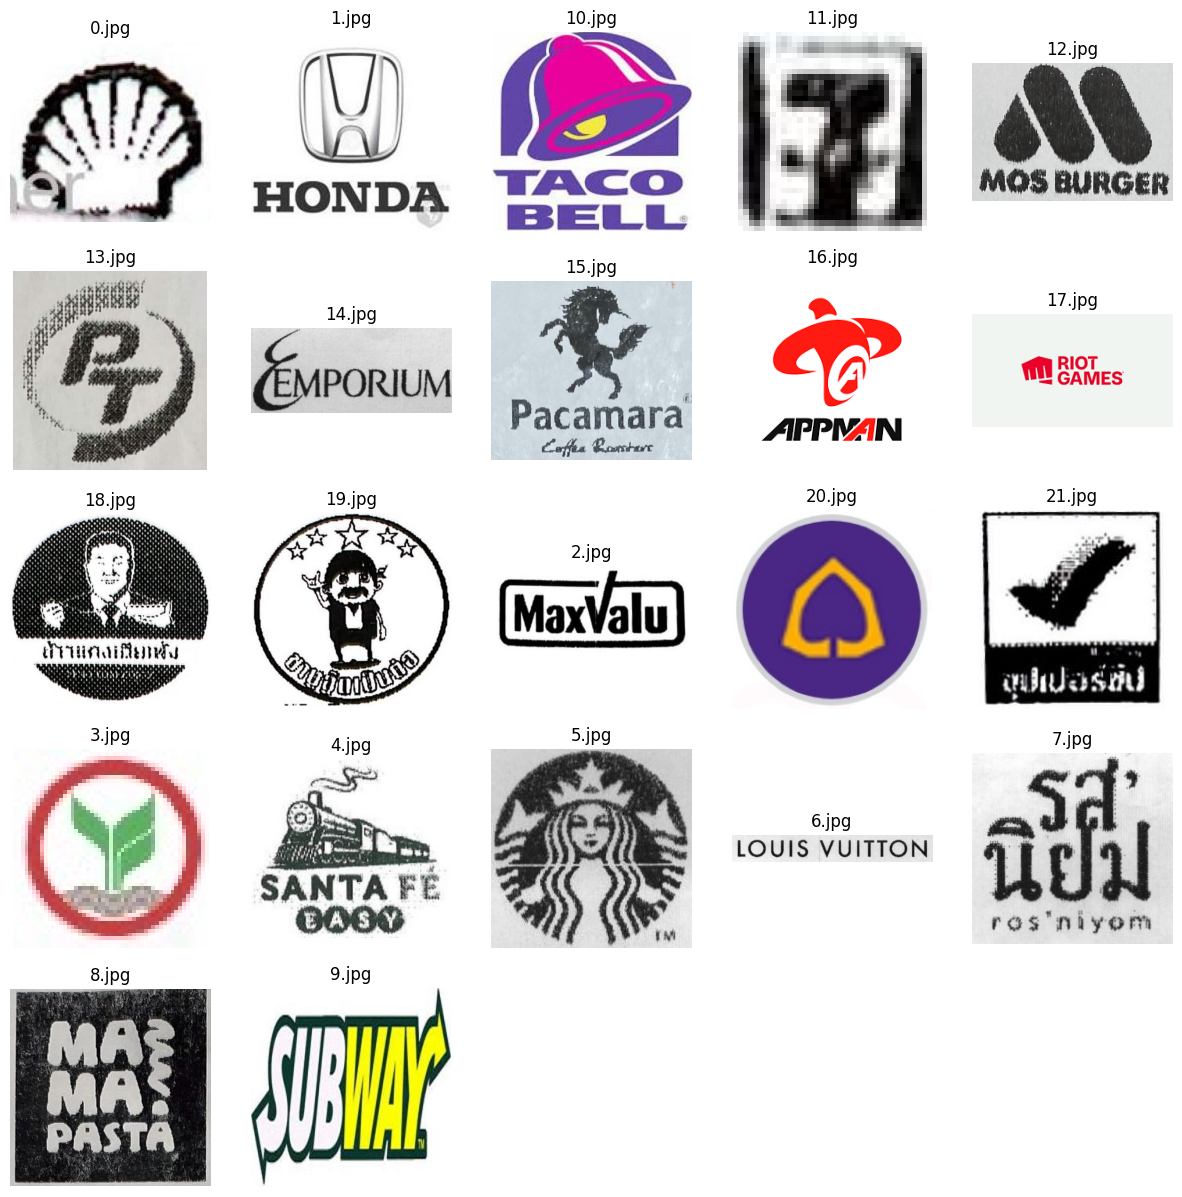

In [60]:
display_images_in_subplot(queries_path)

# Visualize Train and Testing dataset

In [75]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(train_root,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(train_root,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 2196 files belonging to 170 classes.
Using 1757 files for training.
Found 2196 files belonging to 170 classes.
Using 439 files for validation.


In [76]:
class_names = train_dataset.class_names

# Check if training dataset has same labels as queries labels

In [74]:
def search_strings_in_list(my_list, search_strings):
    results = []

    for search_string in search_strings:
        if search_string in my_list:
            results.append(f"'{search_string}' found!")
        else:
            results.append(f"'{search_string}' not found.")

    return results

search_list = ['shell','Shell','Honda','honda','Pacamara','pacamara','subway','Subway','Appman','appman']

search_results = search_strings_in_list(class_names, search_list)
for result in search_results:
    print(result)


'shell' not found.
'Shell' not found.
'Honda' not found.
'honda' not found.
'Pacamara' not found.
'pacamara' not found.
'subway' not found.
'Subway' not found.
'Appman' not found.
'appman' not found.


Due to there are many data labels not found in training dataset, will design to use `few-shot` classification model.

32
32


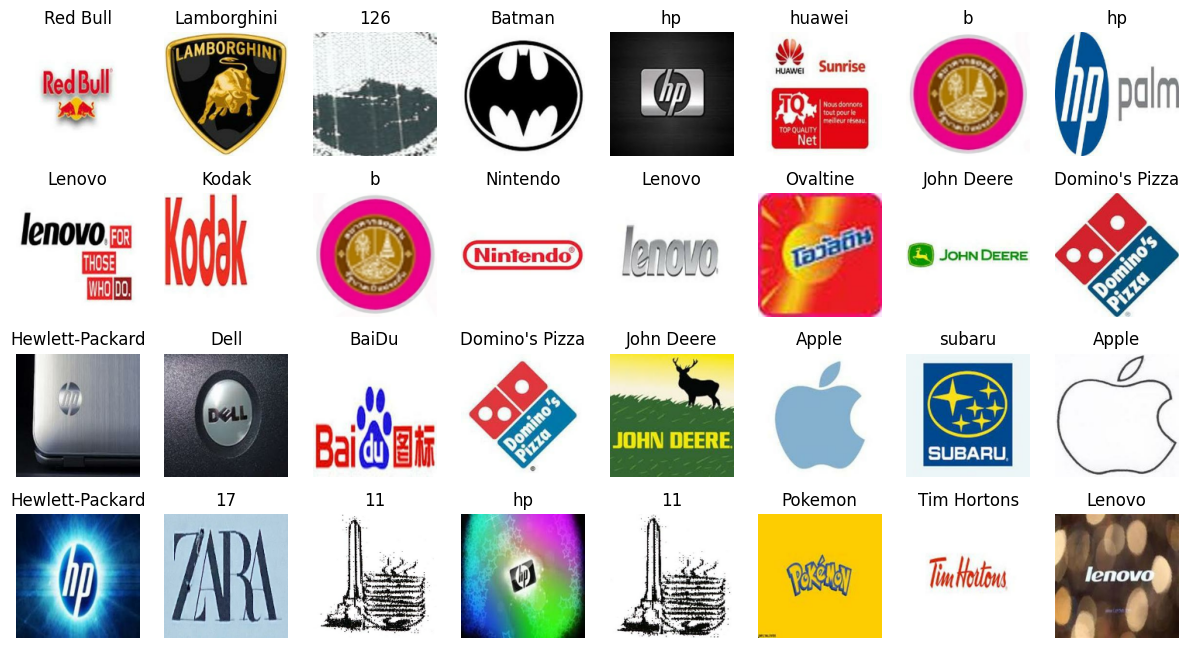

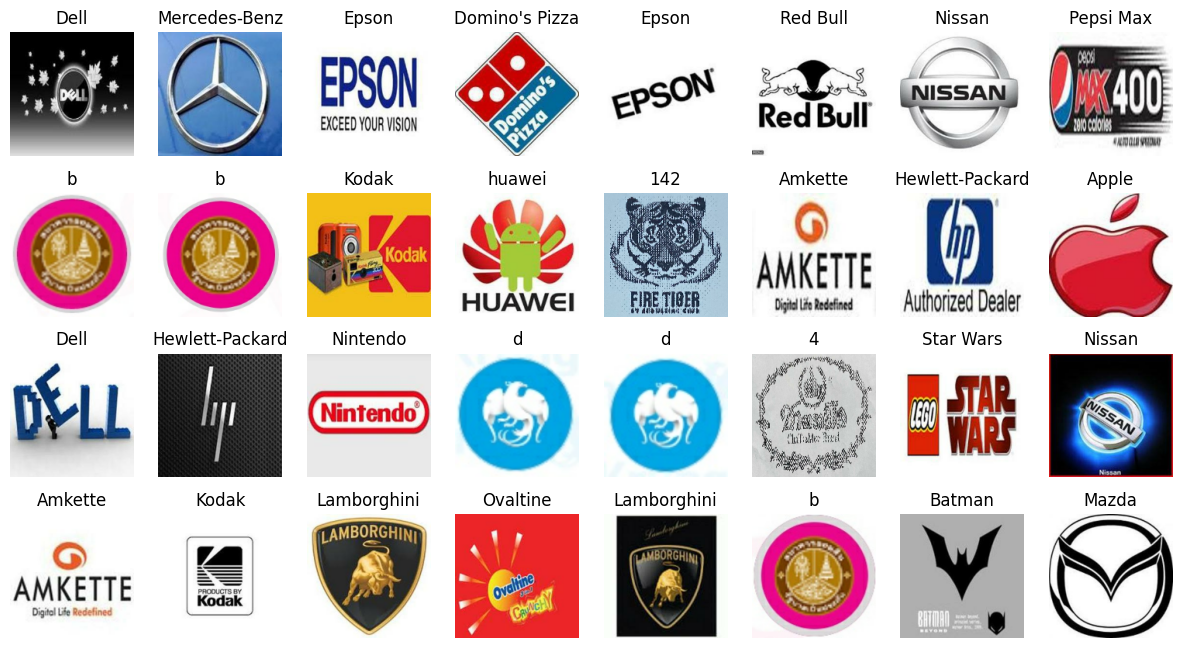

In [91]:
for images, labels in train_dataset.take(2):
    num_columns = 8
    print(len(images))
    num_rows = (len(images) + num_columns - 1) // num_columns
    plt.figure(figsize=(15, 2 * num_rows))
    for i in range(len(images)):
        ax = plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(class_names[labels[i]])
        plt.axis("off")

there are 1120 testing samples


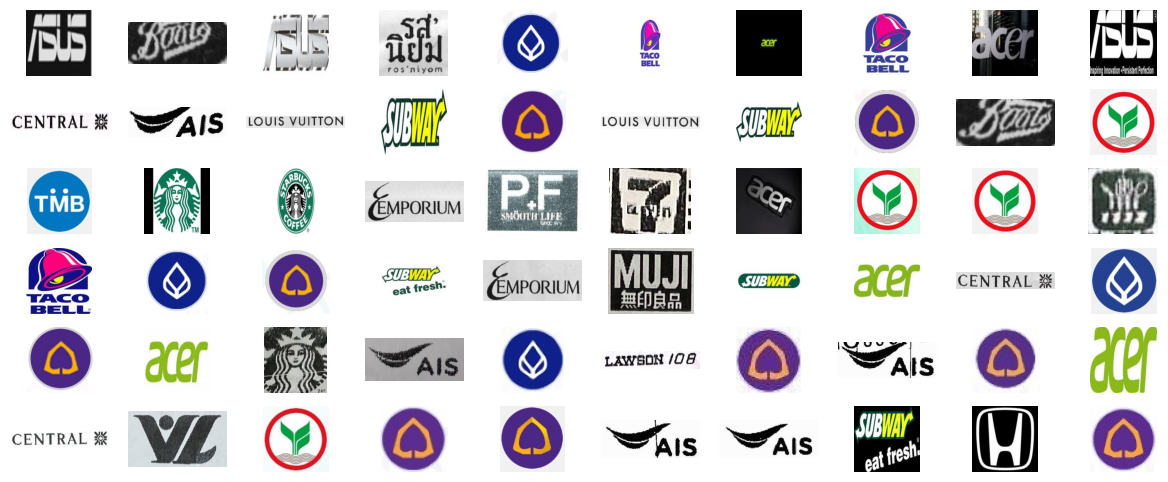

In [86]:
# Create a list of image files in the directory
image_files = [os.path.join(test_root, img) for img in os.listdir(test_root) if img.endswith(('.png', '.jpg', '.jpeg'))]
print('there are {} testing samples'.format(len(image_files)))

# Load and display images in subplots
num_columns = 10
num_rows = (len(image_files) + num_columns - 1) // num_columns

num_rows = 6
plt.figure(figsize=(15, 1 * num_rows))

for i in range(num_columns* num_rows):
    img_path = image_files[i]
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    ax = plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(tf.cast(img_array, tf.uint8))
    plt.axis('off')

plt.show()

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# ZeroShort Learning from benchmark code.

In [96]:
from transformers import (
    AutoModel,
    CLIPProcessor
)
import os
import pandas as pd
from PIL import Image
import torch
from tqdm import tqdm


src_dir = test_root
query_dir = queries_path
submission = pd.read_csv(os.path.join(data_root,'sample_submission.csv'))
model = AutoModel.from_pretrained('openai/clip-vit-base-patch32').eval()
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

submission['dot_class'] = 22
submission['cosine_class'] = 22
with torch.no_grad():
    query_images = []
    query_classes = []
    for file in tqdm(os.listdir(query_dir)):
        inputs = processor(images=[Image.open(os.path.join(query_dir, file)).convert('RGB')], return_tensors='pt').to('cpu')
        outputs = model.get_image_features(inputs.pixel_values).cpu()
        outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
        query_images.append(outputs)
        query_classes.append(int(file[:-4]))
    query_images = torch.cat(query_images)
    for idx, row in tqdm(submission.iterrows()):
        if not pd.isna(row['class']):
            continue
        inputs = processor(images=[Image.open(os.path.join(src_dir, row['img_file'])).convert('RGB')], return_tensors='pt').to('cpu')
        outputs = model.get_image_features(inputs.pixel_values).cpu()
        outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
        values = outputs @ query_images.T
        if values.softmax(1).max() > .055:
            submission.at[idx, 'dot_class'] = query_classes[values.argmax().numpy().tolist()]
        cosine = torch.cosine_similarity(outputs, query_images)
        if cosine.max() > 0.8:
            submission.at[idx, 'cosine_class'] = query_classes[cosine.argmax().numpy().tolist()]

    sub = submission[['img_file',]]
    sub['class'] = submission['dot_class']
    sub.to_csv('dot_product.csv', index=False)
    sub['class'] = submission['cosine_class']
    sub.to_csv('cosine_similarity.csv', index=False)

100%|██████████| 22/22 [00:04<00:00,  5.07it/s]
1120it [03:06,  6.00it/s]
C:\Users\teera\AppData\Local\Temp\ipykernel_22324\3265913462.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['dot_class']
C:\Users\teera\AppData\Local\Temp\ipykernel_22324\3265913462.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['cosine_class']


In [98]:
submission

,img_file,class,dot_class,cosine_class
0,64ccfecf-e451-49a8-aa3f-acf2622a9a5c.jpg,12.0,22,22
1,c6df1385-382a-4428-b41e-f2d729b90c87.jpg,22.0,22,22
2,af30e9d0-da6e-42bd-814e-c70a0c16e554.jpg,22.0,22,22
3,3fc8998e-0324-426c-8233-6b76abc7e200.jpg,NaN,22,22
4,309d1085-0d11-4411-9555-b24cc8fcee02.jpg,NaN,22,22
...,...,...,...,...
1115,43b3052a-11b6-410f-9dae-c8c60b347bb2.jpg,NaN,22,22
1116,ea11503b-de43-43e3-b46b-6a84e528217c.jpg,NaN,22,22
1117,9daf6dc7-ab1c-43fa-a733-ae9131d3686a.jpg,NaN,22,22
1118,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,NaN,22,22


In [102]:
query_classes

[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 3, 4, 5, 6, 7, 8, 9]

In [114]:
for file in tqdm(os.listdir(query_dir)):
    inputs = processor(images=[Image.open(os.path.join(query_dir, file)).convert('RGB')], return_tensors='pt').to('cpu')
    outputs = model.get_image_features(inputs.pixel_values).cpu()
    outputs_before_norm = outputs.clone().detach()
    outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
    break

  0%|          | 0/22 [00:00<?, ?it/s]


File: 0.jpg
Outputs Before Normalization: [[ 2.38566607e-01  3.95211503e-02 -9.63550806e-02 -5.94885170e-01
   3.34525168e-01  1.09219551e-01  1.41947895e-01  6.44810796e-01
   6.95028007e-01  6.04466498e-02  3.09288502e-01  5.95152080e-01
   6.62511706e-01 -9.57438201e-02 -1.06995031e-01  2.02142313e-01
   7.91901946e-01  4.32836898e-02  2.91965455e-01  7.42451772e-02
  -4.66327161e-01  3.25328976e-01 -9.32547674e-02 -2.51159612e-02
   2.63745755e-01 -7.68095702e-02  1.10291932e-02 -4.57538277e-01
   1.68318063e-01  2.48805702e-01 -3.82078886e-02  2.54750133e-01
  -2.37984896e-01  3.61220725e-02 -5.23504078e-01 -3.62955391e-01
  -1.82335511e-01  5.60615122e-01 -3.89619559e-01 -1.19343549e-01
  -5.92755824e-02 -1.71246752e-01  4.10889953e-01 -3.08896571e-01
   1.32760465e-01 -5.30505963e-02 -5.61387762e-02  1.38542786e-01
  -1.38508290e-01  1.74113885e-02  3.60245436e-01  3.29695076e-01
   2.17282884e-02 -1.71277717e-01  2.76836991e-01 -2.46338278e-01
   9.34642702e-02  2.66128808e-01 

<BarContainer object of 512 artists>

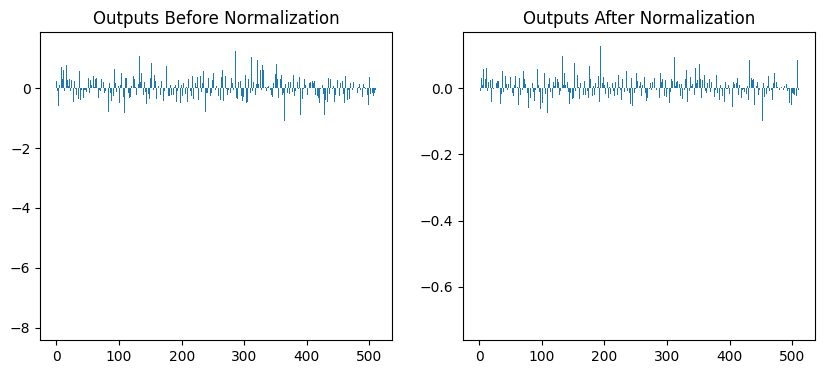

In [119]:
# Print and visualize differences
print(f"File: {file}")
print("Outputs Before Normalization:", outputs_before_norm.numpy())
print("Outputs After Normalization:", outputs.detach().numpy())

# Plot the differences (optional)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Outputs Before Normalization")
plt.bar(range(len(outputs_before_norm[0])), outputs_before_norm[0].numpy())

plt.subplot(1, 2, 2)
plt.title("Outputs After Normalization")
plt.bar(range(len(outputs[0])), outputs[0].detach().numpy())

# Compute F1-score Performance checking

In [152]:
import os
import pandas as pd
from sklearn.metrics import f1_score

def create_dataframe_from_directory(data_root):
    img_files = []
    class_labels = []

    # Iterate through subfolders
    for subfolder in os.listdir(data_root):
        subfolder_path = os.path.join(data_root, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through files in the subfolder
            for file in os.listdir(subfolder_path):
                # Append image filename and class label
                img_files.append(file)
                class_labels.append(int(subfolder))

    # Create DataFrame
    df = pd.DataFrame({'img_file': img_files, 'class': class_labels})
    df.to_csv('./dataset/image-search/test/test_label.csv')
    return df

def compare_dataframes(test_root, pred_file):
    # Create initial df_test supervised
    df_test = create_dataframe_from_directory(test_root)

    # Load predicted dataframe
    df_pred = pd.read_csv(pred_file)

    # Merge dataframes on 'img_file'
    merged_df = pd.merge(df_test, df_pred, on='img_file', how='inner', suffixes=('_true', '_predicted'))

    # Check if there are common rows
    if not merged_df.empty:
        true_labels = merged_df['class_true']
        predicted_labels = merged_df['class_predicted']

        # Calculate F1-score
        f1 = f1_score(true_labels, predicted_labels, average='weighted', labels=merged_df['class_true'].unique())

        # Print F1-score
        return f"F1 Score: {f1}"

    else:
        return "No common rows found for comparison."

# Example usage:
test_root = os.path.join(data_root,'test/images')
pred_files = ['./cosine_similarity.csv', './base32_cosine_similarity.csv', './normal_cosine_similarity.csv', './great_cosine_similarity.csv', \
    './dot_product.csv', './base32_dot_product.csv', './normal_dot_product.csv', './great_dot_product.csv']
for pred_file in pred_files:
    print(pred_file[:-4], '\n\t', compare_dataframes(test_root, pred_file))


./cosine_similarity 
	 F1 Score: 0.8462527824185192
./base32_cosine_similarity 
	 F1 Score: 0.8462527824185192
./normal_cosine_similarity 
	 F1 Score: 0.8170865791637478
./great_cosine_similarity 
	 F1 Score: 0.9324037502487641
./dot_product 
	 F1 Score: 0.8800772522942925
./base32_dot_product 
	 F1 Score: 0.8800772522942925
./normal_dot_product 
	 F1 Score: 0.8756376999917487
./great_dot_product 
	 F1 Score: 0.9140338405893349


F1 Score: 0.9324037502487641
